In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Simulate geospatial and thruster gas data
time_steps = 100
np.random.seed(42)

latitudes = np.cumsum(np.random.normal(0, 0.01, time_steps)) + -8.50
longitudes = np.cumsum(np.random.normal(0, 0.01, time_steps)) + 345.0
altitudes = np.abs(np.cumsum(np.random.normal(0, 0.1, time_steps)) + 1.0)

# Synthetic thruster gas usage
gas_output = np.clip(np.sin(np.linspace(0, 6*np.pi, time_steps)) * 2 + np.random.normal(0, 0.2, time_steps), 0, None)

# DataFrame
df = pd.DataFrame({
    "time": np.arange(time_steps),
    "latitude": latitudes,
    "longitude": longitudes,
    "altitude_km": altitudes,
    "thruster_gas_kg_s": gas_output
})

df.head()


,time,latitude,longitude,altitude_km,thruster_gas_kg_s
0,0,-8.495033,344.985846,1.035779,0.000000
1,1,-8.496416,344.981640,1.091857,0.266466
2,2,-8.489939,344.978213,1.200162,0.892784
3,3,-8.474708,344.970190,1.305543,1.203356
4,4,-8.477050,344.968577,1.167776,1.375978


In [3]:
# Scale inputs and output
features = df[['latitude', 'longitude', 'altitude_km']].values
target = df['thruster_gas_kg_s'].values.reshape(-1, 1)

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Sequence creation
def create_sequences(data, targets, seq_len=5):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(targets[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(features_scaled, target_scaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64)
        c0 = torch.zeros(1, x.size(0), 64)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


Epoch 10: Loss = 0.0840
Epoch 20: Loss = 0.0637
Epoch 30: Loss = 0.0504
Epoch 40: Loss = 0.0481
Epoch 50: Loss = 0.0463
Epoch 60: Loss = 0.0435
Epoch 70: Loss = 0.0401
Epoch 80: Loss = 0.0394
Epoch 90: Loss = 0.0356
Epoch 100: Loss = 0.0328


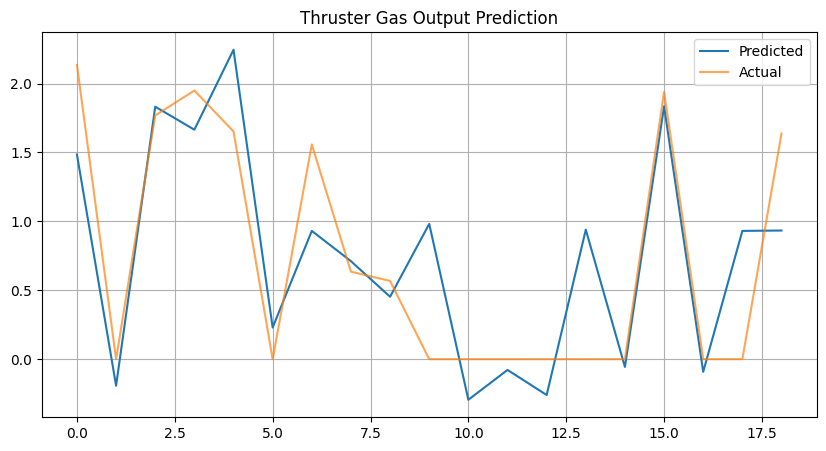

In [5]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions = target_scaler.inverse_transform(predictions)
    actual = target_scaler.inverse_transform(y_test)

# Plot prediction vs actual
plt.figure(figsize=(10, 5))
plt.plot(predictions, label="Predicted")
plt.plot(actual, label="Actual", alpha=0.7)
plt.title("Thruster Gas Output Prediction")
plt.legend()
plt.grid(True)
plt.show()